first we need to train a parametric-umap network for each dataset... (5 datasets x 2 dimensions)
For umap-learn, UMAP AE, Param. UMAP, PCA
- load dataset
- load network
- compute reconstruction MSE
- count time

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import numpy as np
import pickle
import pandas as pd
import time
from umap import UMAP

In [5]:
from tfumap.umap import tfUMAP
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
from tqdm.autonotebook import tqdm

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [8]:
output_dir = MODEL_DIR/'projections' 

In [9]:
reconstruction_acc_df = pd.DataFrame(columns = ['method_', 'dimensions', 'dataset', 'MSE', 'MAE', 'MedAE', 'R2'])

In [10]:
reconstruction_speed_df = pd.DataFrame(columns = ['method_', 'dimensions', 'dataset', 'embed_time', 'recon_time', 'speed', 'nex'])

### MNIST

In [11]:
dataset = 'mnist'
dims = (28,28,1)

##### load dataset

In [12]:
from tensorflow.keras.datasets import mnist

# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
X_test = X_test.reshape((10000, 28,28,1))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### AE 

##### 2 dims

In [13]:
load_loc = output_dir / dataset / 'autoencoder' 

In [14]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [15]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [16]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [17]:
X_recon = tf.nn.relu(decoder(encoder(X_test))).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

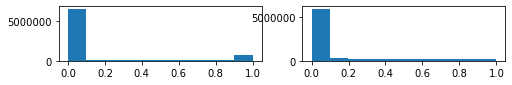

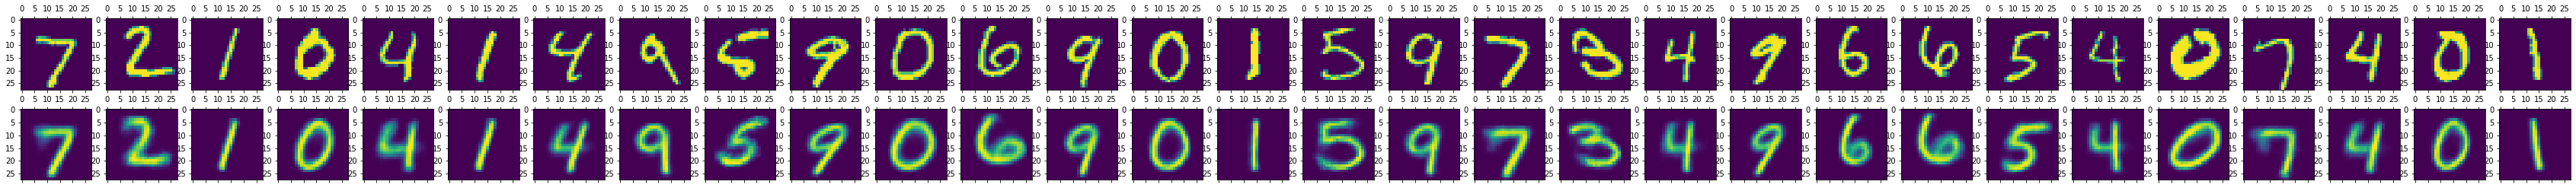

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=2, figsize=(8,1))
axs[0].hist(x_real.flatten())
axs[1].hist(x_recon.flatten())

nex = 30
fig, axs = plt.subplots(nrows=2, ncols=nex, figsize=(nex*2, 2*2))
for i, (real, recon) in enumerate(zip(x_real[:nex], x_recon[:nex])):
    axs[0,i].matshow(np.squeeze(real.reshape(dims)))
    axs[1,i].matshow(np.squeeze(recon.reshape(dims)))

In [19]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [20]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['AE', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,mnist,0.035955,0.080954,0.040411,0.048519


##### 64 dims

In [21]:
load_loc = output_dir / dataset / '64' / 'autoencoder' 

In [22]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [23]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [24]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [25]:
X_recon = tf.nn.relu(decoder(encoder(X_test))).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [26]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [27]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['AE', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,mnist,0.035955,0.080954,0.040411,0.048519
1,AE,64,mnist,0.002684,0.014447,0.001088,-11.882787


### Network

##### 2 dims

In [28]:
load_loc = output_dir / dataset / 'recon-network' 

In [29]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "network",
    batch_size = 100,
    dims = dims
)

In [30]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [31]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [32]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = encoder(X_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = decoder(z_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    recon_time = end_time - start_time
    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "network",
        2,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.04807971487753093
seconds:  0.06775693199597299
seconds:  0.13557924586348236
seconds:  0.004442108096554875
seconds:  0.18870172603055835
seconds:  0.0038740721065551043
seconds:  0.19045652588829398
seconds:  0.004709756001830101
seconds:  0.19006033497862518
seconds:  0.004098108038306236
seconds:  0.18986478890292346
seconds:  0.004095037933439016
seconds:  0.18782206089235842
seconds:  0.0032103019766509533
seconds:  0.19180322508327663
seconds:  0.004321384942159057
seconds:  0.18809833796694875
seconds:  0.004368816036731005
seconds:  0.1908132468815893
seconds:  0.0047903480008244514



In [33]:
with tf.device('/CPU:0'):
    n_repeats = 10
    for i in tqdm(range(n_repeats)):
        start_time = time.monotonic()
        z_test = encoder(X_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        embed_time = end_time - start_time

        start_time = time.monotonic()
        x_test_recon = decoder(z_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        recon_time = end_time - start_time
        reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
            "network-cpu",
            2,
            dataset,
            embed_time,
            recon_time,
            embed_time + recon_time,
        len(X_test_flat)
        ]

seconds:  0.34037954499945045
seconds:  1.7733755731023848
seconds:  0.16480477689765394
seconds:  1.6999832489527762
seconds:  0.15501629607751966
seconds:  1.6654670049902052
seconds:  0.1743539220187813
seconds:  1.735320057021454
seconds:  0.18796115391887724
seconds:  2.0725060109980404
seconds:  0.16266389493830502
seconds:  1.803611075039953
seconds:  0.18968667392618954
seconds:  1.8164070839993656
seconds:  0.17437560390681028
seconds:  1.636024747043848
seconds:  0.15793495997786522
seconds:  1.6706888061016798
seconds:  0.16231532604433596
seconds:  1.9191905849147588



In [34]:
X_recon = tf.nn.relu(decoder(encoder(X_test))).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [35]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [36]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = [
    "network",
    2,
    dataset,
    MSE,
    MAE,
    MedAE,
    R2,
]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,mnist,0.035955,0.080954,0.040411,0.048519
1,AE,64,mnist,0.002684,0.014447,0.001088,-11.882787
2,network,2,mnist,0.037375,0.083731,0.043021,0.219779


##### 64 dims

In [37]:
load_loc = output_dir / dataset / '64' / 'recon-network' 

In [38]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method = "autoencoder",
    batch_size = 100,
    dims = dims
)

In [39]:
encoder = tf.keras.models.load_model((load_loc / 'encoder').as_posix())
embedder.encoder = encoder

In [40]:
decoder = tf.keras.models.load_model((load_loc / 'decoder').as_posix())
embedder.decoder = decoder

In [41]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = encoder(X_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = decoder(z_test)
    end_time = time.monotonic()
    print("seconds: ", end_time - start_time)
    recon_time = end_time - start_time
    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "network",
        64,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.05251229205168784
seconds:  0.06928337505087256
seconds:  0.13638085895217955
seconds:  0.004139229888096452
seconds:  0.19102242216467857
seconds:  0.005655892891809344
seconds:  0.1875505622010678
seconds:  0.004919522209092975
seconds:  0.18840149696916342
seconds:  0.004688085988163948
seconds:  0.19026883109472692
seconds:  0.00604420411400497
seconds:  0.18607781012542546
seconds:  0.005024085054174066
seconds:  0.19283772492781281
seconds:  0.004732086090371013
seconds:  0.18900744407437742
seconds:  0.004666254157200456
seconds:  0.18939979607239366
seconds:  0.004446028033271432



In [42]:
with tf.device("/CPU:0"):
    n_repeats = 10
    for i in tqdm(range(n_repeats)):
        start_time = time.monotonic()
        z_test = encoder(X_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        embed_time = end_time - start_time

        start_time = time.monotonic()
        x_test_recon = decoder(z_test)
        end_time = time.monotonic()
        print("seconds: ", end_time - start_time)
        recon_time = end_time - start_time
        reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
            "network-cpu",
            64,
            dataset,
            embed_time,
            recon_time,
            embed_time + recon_time,
        len(X_test_flat)
        ]

seconds:  0.31082181399688125
seconds:  1.795312485890463
seconds:  0.17176664783619344
seconds:  1.893185646040365
seconds:  0.16523995017632842
seconds:  1.6690745910163969
seconds:  0.1682044160552323
seconds:  1.7159536220133305
seconds:  0.1664927660021931
seconds:  1.695009428076446
seconds:  0.17018988309428096
seconds:  1.6924896261189133
seconds:  0.17019874299876392
seconds:  1.6641429690644145
seconds:  0.16542665497399867
seconds:  1.7117113799322397
seconds:  0.16038748994469643
seconds:  1.7273002888541669
seconds:  0.17079860996454954
seconds:  1.6956382668577135



In [43]:
reconstruction_speed_df[:3]

,method_,dimensions,dataset,embed_time,recon_time,speed,nex
0,network,2,mnist,0.048080,0.067757,0.115837,10000
1,network,2,mnist,0.135579,0.004442,0.140021,10000
2,network,2,mnist,0.188702,0.003874,0.192576,10000


In [44]:
X_recon = tf.nn.relu(decoder(encoder(X_test))).numpy()
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [45]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

In [46]:
reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['network', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,mnist,0.035955,0.080954,0.040411,0.048519
1,AE,64,mnist,0.002684,0.014447,0.001088,-11.882787
2,network,2,mnist,0.037375,0.083731,0.043021,0.219779
3,network,64,mnist,0.031332,0.073505,0.033229,-0.376022


#### UMAP-learn

##### 2 dims

In [47]:
embedder = UMAP(n_components = 2, verbose=True)
z_umap = embedder.fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sat Jul 18 11:14:32 2020 Finding Nearest Neighbors
Sat Jul 18 11:14:32 2020 Building RP forest with 16 trees
Sat Jul 18 11:14:34 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Sat Jul 18 11:14:45 2020 Finished Nearest Neighbor Search
Sat Jul 18 11:14:47 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jul 18 11:15:17 2020 Finished embedding


In [48]:
x_test_samples= []
x_test_recon_samples= []
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = embedder.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    embed_time = end_time - start_time

    nex = 10 # it would take far too long to reconstruct the entire dataset
    samp_idx = np.random.randint(len(z_test),  size= nex)
    sample = np.array(z_test)[samp_idx]
    x_test_samples.append(samp_idx)
    start_time = time.monotonic()
    x_test_recon = embedder.inverse_transform(sample);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    recon_time = (end_time - start_time)*len(z_test)/nex

    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "umap-learn",
        2,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]
    x_test_recon_samples.append(x_test_recon)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  18.78321402007714
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  56.270065859891474
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
seconds:  5.977272775024176
	completed  0  /  

In [49]:
x_recon = np.concatenate(x_test_recon_samples)

In [50]:
x_real = np.array(X_test_flat)[np.concatenate(x_test_samples)]

In [51]:

MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['umap-learn', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,mnist,0.035955,0.080954,0.040411,0.048519
1,AE,64,mnist,0.002684,0.014447,0.001088,-11.882787
2,network,2,mnist,0.037375,0.083731,0.043021,0.219779
3,network,64,mnist,0.031332,0.073505,0.033229,-0.376022
4,umap-learn,2,mnist,0.039312,0.098128,0.067867,-0.157930


##### PCA

##### 2 dims


In [52]:
pca = PCA(n_components=2)
z = pca.fit_transform(X_train_flat)

In [53]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = pca.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = pca.inverse_transform(z_test);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    recon_time = (end_time - start_time)

    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "pca",
        2,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.010349307907745242
seconds:  0.016990039963275194
seconds:  0.010479332180693746
seconds:  0.02470860304310918
seconds:  0.009389179991558194
seconds:  0.013677514856681228
seconds:  0.009859394049271941
seconds:  0.012727197026833892
seconds:  0.009761702036485076
seconds:  0.012721447041258216
seconds:  0.009627907071262598
seconds:  0.012780658900737762
seconds:  0.009824004024267197
seconds:  0.013886430067941546
seconds:  0.009689799044281244
seconds:  0.01286296104080975
seconds:  0.009678259026259184
seconds:  0.012939003063365817
seconds:  0.00989336590282619
seconds:  0.012702385894954205



In [54]:
X_recon = pca.inverse_transform(pca.transform(X_test_flat))
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['pca', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,mnist,0.035955,0.080954,0.040411,0.048519
1,AE,64,mnist,0.002684,0.014447,0.001088,-11.882787
2,network,2,mnist,0.037375,0.083731,0.043021,0.219779
3,network,64,mnist,0.031332,0.073505,0.033229,-0.376022
4,umap-learn,2,mnist,0.039312,0.098128,0.067867,-0.157930
5,pca,2,mnist,0.055667,0.130651,0.112987,0.145549


##### 64 dims

In [55]:
pca = PCA(n_components=64)
z = pca.fit_transform(X_train_flat)

In [56]:
n_repeats = 10
for i in tqdm(range(n_repeats)):
    start_time = time.monotonic()
    z_test = pca.transform(X_test_flat);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    embed_time = end_time - start_time

    start_time = time.monotonic()
    x_test_recon = pca.inverse_transform(z_test);
    end_time = time.monotonic()
    print('seconds: ', end_time - start_time)
    recon_time = (end_time - start_time)

    reconstruction_speed_df.loc[len(reconstruction_speed_df)] = [
        "pca",
        64,
        dataset,
        embed_time,
        recon_time,
        embed_time + recon_time,
        len(X_test_flat)
    ]

seconds:  0.014473286923021078
seconds:  0.019930025096982718
seconds:  0.014566730940714478
seconds:  0.01586883794516325
seconds:  0.015583788976073265
seconds:  0.01592417899519205
seconds:  0.014985451940447092
seconds:  0.016177616082131863
seconds:  0.015708262799307704
seconds:  0.01710262382403016
seconds:  0.015303591033443809
seconds:  0.016569416970014572
seconds:  0.016035383101552725
seconds:  0.01655597798526287
seconds:  0.015293471049517393
seconds:  0.016628409968689084
seconds:  0.0160977840423584
seconds:  0.01647517504170537
seconds:  0.01528386096470058
seconds:  0.01710090390406549



In [57]:
X_recon = pca.inverse_transform(pca.transform(X_test_flat))
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['pca', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,mnist,0.035955,0.080954,0.040411,0.048519
1,AE,64,mnist,0.002684,0.014447,0.001088,-11.882787
2,network,2,mnist,0.037375,0.083731,0.043021,0.219779
3,network,64,mnist,0.031332,0.073505,0.033229,-0.376022
4,umap-learn,2,mnist,0.039312,0.098128,0.067867,-0.157930
5,pca,2,mnist,0.055667,0.130651,0.112987,0.145549
6,pca,64,mnist,0.009049,0.051964,0.037784,0.440804


### Save

In [58]:
#save_loc = DATA_DIR / 'reconstruction_speed' / (dataset + '.pickle')
#ensure_dir(save_loc)
#reconstruction_speed_df.to_pickle(save_loc)

In [59]:
save_loc = DATA_DIR / 'reconstruction_acc' / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

### compute reconstruction speed/quality